
#  the model in this file comes from this website

#  https://geertlitjens.nl/post/getting-started-with-camelyon/



#  without editing the model, it is 80% accurate/confident

In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds

pcam, pcam_info = tfds.load('patch_camelyon', shuffle_files=True, with_info=True)

In [2]:
print(pcam)

{'test': <DatasetV1Adapter shapes: {id: (), image: (96, 96, 3), label: ()}, types: {id: tf.string, image: tf.uint8, label: tf.int64}>, 'train': <DatasetV1Adapter shapes: {id: (), image: (96, 96, 3), label: ()}, types: {id: tf.string, image: tf.uint8, label: tf.int64}>, 'validation': <DatasetV1Adapter shapes: {id: (), image: (96, 96, 3), label: ()}, types: {id: tf.string, image: tf.uint8, label: tf.int64}>}


In [0]:
# Import NumPy to handle array's and Matplotlib for plotting loss curves
import numpy as np
import matplotlib.pyplot as plt

# Import TensorFlow and relevant Keras classes to setup the model
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

In [0]:
#First setup the input to the network which has the dimensions of the patches contained within PatchCAMELYON
input_img = Input(shape=(96,96,3))

# Now we define the layers of the convolutional network: three blocks of two convolutional layers and a max-pool layer.
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(input_img)
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

# Now we flatten the output from a 4D to a 2D tensor to be able to use fully-connected (dense) layers for the final
# classification part. Here we also use a bit of dropout for regularization. The last layer uses a softmax to obtain class
# likelihoods (i.e. metastasis vs. non-metastasis)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.2)(x)
predictions = Dense(2, activation='softmax')(x)

# Now we define the inputs/outputs of the model and setup the optimizer. In this case we use regular stochastic gradient
# descent with Nesterov momentum. The loss we use is cross-entropy and we would like to output accuracy as an additional metric.
model2 = Model(inputs=input_img, outputs=predictions)
sgd_opt = SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=True)
model2.compile(optimizer=sgd_opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
#model.summary()

In [0]:
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

In [0]:
train_pipeline = pcam['train'].map(convert_sample,
                                   num_parallel_calls=8).shuffle(1024).repeat().batch(64).prefetch(2)
valid_pipeline = pcam['validation'].map(convert_sample,
                                        num_parallel_calls=8).repeat().batch(128).prefetch(2)

In [7]:
hist2 = model2.fit(train_pipeline,
                 validation_data=valid_pipeline,
                 verbose=2, epochs=10, steps_per_epoch=4096, validation_steps=256)

Epoch 1/10
4096/4096 - 198s - loss: 0.4473 - accuracy: 0.7897 - val_loss: 0.4121 - val_accuracy: 0.8274
Epoch 2/10
4096/4096 - 200s - loss: 0.3104 - accuracy: 0.8696 - val_loss: 0.3744 - val_accuracy: 0.8369
Epoch 3/10
4096/4096 - 205s - loss: 0.2537 - accuracy: 0.8988 - val_loss: 0.4709 - val_accuracy: 0.8031
Epoch 4/10
4096/4096 - 201s - loss: 0.2202 - accuracy: 0.9144 - val_loss: 0.3811 - val_accuracy: 0.8396
Epoch 5/10
4096/4096 - 215s - loss: 0.1977 - accuracy: 0.9244 - val_loss: 0.3377 - val_accuracy: 0.8533
Epoch 6/10
4096/4096 - 225s - loss: 0.1806 - accuracy: 0.9314 - val_loss: 0.3877 - val_accuracy: 0.8424
Epoch 7/10
4096/4096 - 217s - loss: 0.1663 - accuracy: 0.9372 - val_loss: 0.3380 - val_accuracy: 0.8640
Epoch 8/10
4096/4096 - 228s - loss: 0.1530 - accuracy: 0.9426 - val_loss: 0.4126 - val_accuracy: 0.8493
Epoch 9/10
4096/4096 - 224s - loss: 0.1409 - accuracy: 0.9472 - val_loss: 0.4474 - val_accuracy: 0.8361
Epoch 10/10
4096/4096 - 216s - loss: 0.1287 - accuracy: 0.9522 -

In [8]:
test_pipeline = pcam['test'].map(convert_sample, num_parallel_calls=8).batch(128).prefetch(2)
print("Test set accuracy is {0:.4f}".format(model2.evaluate(test_pipeline, steps=128, verbose=0)[1]))

Test set accuracy is 0.7961


In [9]:
model2.save("patchcamelyon2.hf5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: patchcamelyon2.hf5/assets


INFO:tensorflow:Assets written to: patchcamelyon2.hf5/assets


In [10]:
#Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras import optimizers
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
%matplotlib inline
sns.set_style("whitegrid")
np.random.seed(697)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


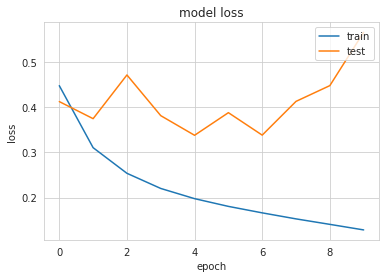

In [11]:
# summarize history for loss
plt.figure()
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [12]:
# Import NumPy to handle array's and Matplotlib for plotting loss curves
import numpy as np
import matplotlib.pyplot as plt

# Import TensorFlow and relevant Keras classes to setup the model
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

#just some network parameters, see above link regarding the layers for details
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

#dropout is used for regularization here with a probability of 0.3 for conv layers, 0.5 for the dense layer at the end
dropout_conv = 0.3
dropout_dense = 0.5

#initialize the model
model = Sequential()

#now add layers to it

#conv block 1
model.add(Conv2D(first_filters, kernel_size, input_shape = (96, 96, 1)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

#conv block 2
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#conv block 3
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#a fully connected (also called dense) layer at the end
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))

model.add(Dense(2, activation = "softmax"))

model.compile(optimizer=Adam(0.001),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])
#model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 94, 94, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 94, 94, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 92, 92, 32)        9216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 92, 92, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 92, 92, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 46, 32)        0

In [0]:
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.rgb_to_grayscale(image)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

In [0]:
train_pipeline = pcam['train'].map(convert_sample,
                                   num_parallel_calls=8).shuffle(1024).repeat().batch(64).prefetch(2)
valid_pipeline = pcam['validation'].map(convert_sample,
                                        num_parallel_calls=8).repeat().batch(128).prefetch(2)



In [15]:
hist = model.fit(train_pipeline,
                 validation_data=valid_pipeline,
                 verbose=2, epochs=10, steps_per_epoch=256, validation_steps=256)



Epoch 1/10
256/256 - 38s - loss: 0.5687 - accuracy: 0.7491 - val_loss: 1.3629 - val_accuracy: 0.5103
Epoch 2/10
256/256 - 44s - loss: 0.4938 - accuracy: 0.7749 - val_loss: 1.0521 - val_accuracy: 0.6055
Epoch 3/10
256/256 - 47s - loss: 0.4664 - accuracy: 0.7914 - val_loss: 0.5770 - val_accuracy: 0.7365
Epoch 4/10
256/256 - 39s - loss: 0.4579 - accuracy: 0.7928 - val_loss: 0.5113 - val_accuracy: 0.7593
Epoch 5/10
256/256 - 42s - loss: 0.4444 - accuracy: 0.7997 - val_loss: 0.4879 - val_accuracy: 0.7854
Epoch 6/10
256/256 - 43s - loss: 0.4297 - accuracy: 0.8125 - val_loss: 0.5447 - val_accuracy: 0.7730
Epoch 7/10
256/256 - 38s - loss: 0.4283 - accuracy: 0.8143 - val_loss: 0.5023 - val_accuracy: 0.7682
Epoch 8/10
256/256 - 43s - loss: 0.4177 - accuracy: 0.8182 - val_loss: 0.5167 - val_accuracy: 0.7955
Epoch 9/10
256/256 - 45s - loss: 0.3959 - accuracy: 0.8278 - val_loss: 0.8926 - val_accuracy: 0.6402
Epoch 10/10
256/256 - 45s - loss: 0.3868 - accuracy: 0.8366 - val_loss: 0.7990 - val_accura

In [16]:
test_pipeline = pcam['test'].map(convert_sample, num_parallel_calls=8).batch(128).prefetch(2)
print("Test set accuracy is {0:.4f}".format(model.evaluate(test_pipeline, steps=128, verbose=0)[1]))

Test set accuracy is 0.5424


In [17]:
model.save("patchcamelyon.hf5")

INFO:tensorflow:Assets written to: patchcamelyon.hf5/assets


INFO:tensorflow:Assets written to: patchcamelyon.hf5/assets


In [0]:
# #Import modules
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.model_selection import train_test_split
# from keras.models import Sequential
# from keras.layers import Activation, Dense, Dropout
# from keras import optimizers
# from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
# %matplotlib inline
# sns.set_style("whitegrid")
# np.random.seed(697)

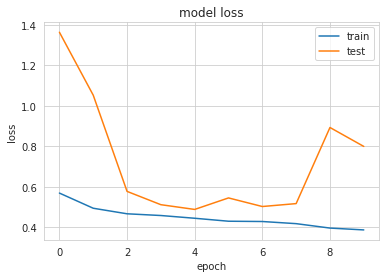

In [19]:
# summarize history for loss
plt.figure()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [0]:
# test_x = []
# test_y = []
# for i in pcam['test']:
#   x,y = convert_sample(i)
#   test_x.append(x)
#   test_y.append(y)

In [0]:

# #Predict on test set
# predictions_NN_prob = model.predict(test_x)
# predictions_NN_prob = predictions_NN_prob[:,0]

# predictions_NN_01 = np.where(predictions_NN_prob > 0.5, 1, 0) #Turn probability to 0-1 binary output

# #Print accuracy
# acc_NN = accuracy_score(test_y, predictions_NN_01)
# print('Overall accuracy of Neural Network model:', acc_NN)

In [0]:
# #Print Area Under Curve
# false_positive_rate, recall, thresholds = roc_curve(test_y, predictions_NN_prob)
# roc_auc = auc(false_positive_rate, recall)
# plt.figure()
# plt.title('Receiver Operating Characteristic (ROC)')
# plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
# plt.legend(loc='lower right')
# plt.plot([0,1], [0,1], 'r--')
# plt.xlim([0.0,1.0])
# plt.ylim([0.0,1.0])
# plt.ylabel('Recall')
# plt.xlabel('Fall-out (1-Specificity)')
# plt.show()

In [0]:
# #Print Confusion Matrix
# cm = confusion_matrix(test_y, predictions_NN_01)
# labels = ['No Default', 'Default']
# plt.figure(figsize=(8,6))
# sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
# plt.title('Confusion Matrix')
# plt.ylabel('True Class')
# plt.xlabel('Predicted Class')
# plt.show()